# Qiskit Course - Lesson 5: Variational Quantum Algorithms (VQAs) & Hybrid Quantum-Classical Workflows

Welcome to Lesson 5 of our quantum computing journey! Building on our understanding of error correction and noise mitigation, we now explore the most promising algorithms for near-term quantum computers: **Variational Quantum Algorithms (VQAs)**. These hybrid quantum-classical algorithms represent the current frontier of practical quantum computing, offering quantum advantage while remaining resilient to noise.

## 🚀 Installation Requirements

In [2]:
# Install required packages for variational algorithms
!pip install qiskit[all]~=2.1.1
!pip install qiskit-aer~=0.17
!pip install qiskit-ibm-runtime~=0.41.1
!pip install qiskit-algorithms~=0.3.0
!pip install qiskit-optimization~=0.6.0
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install scipy
!pip install networkx
!pip install plotly
!pip install pylatexenc

     ---------------------------------------- 0.0/646.5 kB ? eta -:--:--
     ---------------------------------------- 0.0/646.5 kB ? eta -:--:--
     -------------------------------------- 646.5/646.5 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for docplex: filename=docplex-2.30.251-py3-none-any.whl size=686004 sha256=608829e97ecd847cd4f690c985bcdfffe96d54a32428529ac09d0ba5490ee238
  Stored in directory: c:\users\cristian\appdata\local\pip\cache\wheels\c1\d9\5c\1d919b1e441ebbaff244513a13d09c3c0378401601d4184bb0
Successfully built docplex

   -------------------

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 1.7 MB/s eta 0:00:06
   ---- ----------------------------------- 1.0/9.8 MB 2.3 MB/s eta 0:00:04
   ------- -------------------------------- 1.8/9.8 MB 2.5 MB/s eta 0:00:04
   --------- ------------------------------ 2.4/9.8 MB 2.5 MB/s eta 0:00:03
   ----------- ---------------------------- 2.9/9.8 MB 2.5 MB/s eta 0:00:03
   ------------- -------------------------- 3.4/9.8 MB 2.6 MB/s eta 0:00:03
   ----------------- ---------------------- 4.2/9.8 MB 2.7 MB/s eta 0:00:03
   ------------------- -------------------- 4.7/9.8 MB 2.7 MB/s eta 0:00:02
   ---------------------- ----------------- 5.5/9.8 MB 2.8 MB/s eta 0:00:02
   -------------------------- ------------- 6.6/9.8 MB 3.0 MB/s eta 0:00:02
   ----------------------------- ---------- 7.3/9.8 MB 3.1 MB/s eta 0:00:01
   -----------------------

In [14]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.sparse import csr_matrix
import networkx as nx

# Qiskit core
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator, SamplerV2 as AerSampler
from qiskit_aer.noise import NoiseModel, depolarizing_error

# Qiskit algorithms and optimization
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix
from qiskit.visualization import plot_histogram, circuit_drawer
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, TwoLocal

# For optimization, we'll use scipy directly since qiskit optimizers have compatibility issues
# We can implement simple wrappers if needed
from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')

# Set up plotting style for beautiful visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 12,
    'font.weight': 'bold',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# Create simple optimizer wrappers to match the expected interface
class SimpleOptimizer:
    def __init__(self, method='COBYLA', maxiter=100):
        self.method = method
        self.maxiter = maxiter
    
    def minimize(self, fun, x0):
        result = minimize(fun, x0, method=self.method, 
                         options={'maxiter': self.maxiter})
        return result

# Create optimizer instances
SPSA = SimpleOptimizer('Powell', 100)  # Powell is gradient-free like SPSA
COBYLA = SimpleOptimizer('COBYLA', 100)
L_BFGS_B = SimpleOptimizer('L-BFGS-B', 100)
SLSQP = SimpleOptimizer('SLSQP', 100)

print("✅ All imports successful for Variational Quantum Algorithms!")
print("📊 Using SciPy optimizers with simple wrappers")

✅ All imports successful for Variational Quantum Algorithms!
📊 Using SciPy optimizers with simple wrappers


## 📚 What are Variational Quantum Algorithms?

**Variational Quantum Algorithms (VQAs)** are hybrid quantum-classical algorithms that use parameterized quantum circuits (PQCs) to prepare quantum states, combined with classical optimization to find optimal parameters. They represent the most promising approach for achieving quantum advantage on near-term, noisy intermediate-scale quantum (NISQ) devices.

### **🎯 The VQA Paradigm:**

#### **1. Core Components**
- **Parameterized Quantum Circuit (PQC)**: Quantum circuit with tunable parameters
- **Cost Function**: Classical function measuring circuit performance
- **Classical Optimizer**: Algorithm to minimize the cost function
- **Measurement Strategy**: How to extract information from quantum states

#### **2. The Hybrid Loop**
The heart of VQAs is an iterative optimization loop:

\\[ \text{Parameters} \xrightarrow{\text{Quantum}} \text{Measurements} \xrightarrow{\text{Classical}} \text{Updated Parameters} \\]

#### **3. Mathematical Framework**
Given a parameterized quantum state \\(|\psi(\theta)\rangle\\), we minimize:

\\[ C(\theta) = \langle\psi(\theta)|H|\psi(\theta)\rangle \\]

where \(H\) is the problem Hamiltonian and \(\theta\) are the variational parameters.

🧬 VARIATIONAL QUANTUM ALGORITHMS FUNDAMENTALS
======================================================================

🎯 WHAT MAKES VQAs SPECIAL?
   • Hybrid quantum-classical approach
   • Noise-resilient (short circuit depth)
   • Flexible problem encoding
   • Scalable to larger systems
   • Compatible with NISQ hardware

🔄 THE VQA WORKFLOW:
   1. INITIALIZE: Start with random parameters θ₀
   2. PREPARE: Create quantum state |ψ(θ)⟩ using PQC
   3. MEASURE: Extract expectation values ⟨H⟩
   4. OPTIMIZE: Update parameters θ → θ'
   5. ITERATE: Repeat until convergence

⚙️ KEY COMPONENTS:
   • Parameterized Quantum Circuit (PQC):
     → Ansatz: specific circuit structure
     → Parameters: rotation angles, gate parameters
     → Depth: balance expressivity vs noise

   • Cost Function:
     → Problem-specific objective
     → Expectation values of observables
     → Landscape optimization challenges

   • Classical Optimizer:
     → Gradient-free: SPSA, COBYLA, Nelder-Mead
     → Gradient-based: L-BFGS-B, SLSQP (when gradients available)
     → Noise-aware: robust to measurement uncertainty

🎨 ANSATZ DESIGN PRINCIPLES:
   • Expressivity: Can represent good approximations
   • Trainability: Avoids barren plateaus
   • Efficiency: Minimal circuit depth
   • Hardware compatibility: Native gate sets

🌟 MAJOR VQA FAMILIES:
   • VQE (Variational Quantum Eigensolver):
     → Ground state problems
     → Quantum chemistry, materials science

   • QAOA (Quantum Approximate Optimization Algorithm):
     → Combinatorial optimization
     → Graph problems, scheduling

   • VQC (Variational Quantum Classifier):
     → Machine learning classification
     → Feature maps and trainable circuits

   • QGAN (Quantum Generative Adversarial Networks):
     → Generative modeling
     → Distribution learning

🚧 CHALLENGES & SOLUTIONS:
   • Barren Plateaus:
     → Problem: Exponentially vanishing gradients
     → Solution: Problem-inspired ansätze, local optimizers

   • Noise Resilience:
     → Problem: Measurement errors, decoherence
     → Solution: Error mitigation, robust optimizers

   • Classical Simulation:
     → Problem: Hard to verify quantum advantage
     → Solution: Structured problems, benchmarking

## 🧪 Implementing Variational Quantum Eigensolver (VQE)

Let's implement VQE, the most fundamental VQA for finding ground states of quantum systems.

In [31]:
# 1) Recreate H₂ Hamiltonian and ansatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes

h2_terms = [
    ('II', -1.052373245772859),
    ('ZI',  0.39793742484318045),
    ('IZ', -0.39793742484318045),
    ('ZZ', -0.01128010425623538),
    ('XX',  0.18093119978423156),
    ('YY',  0.18093119978423156)
]
h2_hamiltonian = SparsePauliOp.from_list(h2_terms)
ansatz = RealAmplitudes(num_qubits=2, reps=2)

# 2) Define VQE class using existing SimpleOptimizer instances
class VariationalQuantumEigensolver:
    def __init__(self, hamiltonian, ansatz, optimizer_name='SPSA', shots=1024):
        self.hamiltonian = hamiltonian
        self.ansatz = ansatz
        self.shots = shots
        optimizer_map = {
            'SPSA': SPSA,
            'COBYLA': COBYLA,
            'L_BFGS_B': L_BFGS_B,
            'SLSQP': SLSQP
        }
        self.optimizer = optimizer_map.get(optimizer_name, SPSA)
        self.estimator = AerEstimator()
        self.estimator.options.default_shots = shots
        self.optimization_history = {'parameters': [], 'energies': [], 'iterations': []}
        self.iteration = 0
        print("🧬 VQE INITIALIZATION")
        print(f"   • Hamiltonian terms: {len(hamiltonian)}")
        print(f"   • Ansatz parameters: {ansatz.num_parameters}")
        print(f"   • Ansatz depth: {ansatz.depth()}")
        print(f"   • Optimizer: {type(self.optimizer).__name__}")
        print(f"   • Shots per measurement: {shots}")

    def cost_function(self, parameters):
        bound = self.ansatz.assign_parameters(parameters).decompose()
        job = self.estimator.run([(bound, self.hamiltonian)])
        energy = float(job.result()[0].data.evs)
        self.optimization_history['parameters'].append(parameters.copy())
        self.optimization_history['energies'].append(energy)
        self.optimization_history['iterations'].append(self.iteration)
        print(f"   Iteration {self.iteration}: Energy = {energy:.6f}")
        self.iteration += 1
        return energy

    def optimize(self, initial_parameters=None):
        print("\n🚀 STARTING VQE OPTIMIZATION")
        if initial_parameters is None:
            initial_parameters = 2 * np.pi * np.random.random(self.ansatz.num_parameters)
        print(f"   Initial parameters shape: {initial_parameters.shape}")
        print(f"   Initial energy estimate: {self.cost_function(initial_parameters):.6f}")
        self.iteration = 0
        result = self.optimizer.minimize(fun=self.cost_function, x0=initial_parameters)
        optimal_params = result.x
        optimal_energy = result.fun
        print("\n✅ OPTIMIZATION COMPLETE")
        print(f"   • Final energy: {optimal_energy:.6f}")
        print(f"   • Total iterations: {len(self.optimization_history['energies'])}")
        print(f"   • Success: {getattr(result, 'success', 'Unknown')}")
        return {'optimal_parameters': optimal_params,
                'optimal_energy': optimal_energy,
                'history': self.optimization_history}

    def get_optimal_state(self, optimal_parameters):
        bound = self.ansatz.assign_parameters(optimal_parameters).decompose()
        sv_sim = AerSimulator(method='statevector')
        job = sv_sim.run(bound)
        return job.result().get_statevector()

# 3) Run VQE demonstration
vqe = VariationalQuantumEigensolver(
    hamiltonian=h2_hamiltonian,
    ansatz=ansatz,
    optimizer_name='SPSA',
    shots=1024
)
vqe_results = vqe.optimize()
exact_energy = -1.857  # Known H₂ ground state

# 4) Summary output
print(f"Final VQE energy: {vqe_results['optimal_energy']:.6f} hartree")
print(f"Exact ground energy: {exact_energy:.6f} hartree")



🧬 VQE INITIALIZATION
   • Hamiltonian terms: 6
   • Ansatz parameters: 6
   • Ansatz depth: 1
   • Optimizer: SimpleOptimizer
   • Shots per measurement: 1024

🚀 STARTING VQE OPTIMIZATION
   Initial parameters shape: (6,)
   Iteration 0: Energy = -1.406172
   Initial energy estimate: -1.406172
   Iteration 0: Energy = -1.406172
   Iteration 1: Energy = -1.406172
   Iteration 2: Energy = -1.636651
   Iteration 3: Energy = -1.321071
   Iteration 4: Energy = -1.609857
   Iteration 5: Energy = -1.583219
   Iteration 6: Energy = -1.643563
   Iteration 7: Energy = -1.643541
   Iteration 8: Energy = -1.643531
   Iteration 9: Energy = -1.643563
   Iteration 10: Energy = -1.375212
   Iteration 11: Energy = -1.398048
   Iteration 12: Energy = -1.650753
   Iteration 13: Energy = -1.586347
   Iteration 14: Energy = -1.665129
   Iteration 15: Energy = -1.665128
   Iteration 16: Energy = -1.665126
   Iteration 17: Energy = -1.665129
   Iteration 18: Energy = -1.148527
   Iteration 19: Energy = -1.77

In [32]:
# Check the real exact ground state of our Hamiltonian
dense_hamiltonian = h2_hamiltonian.to_matrix()
exact_eigenvalues = np.linalg.eigvals(dense_hamiltonian)
true_exact_energy = np.min(exact_eigenvalues.real)

print(f"VQE energy:        {vqe_results['optimal_energy']:.6f} hartree")
print(f"Literature value:  -1.857000 hartree") 
print(f"Our Hamiltonian:   {true_exact_energy:.6f} hartree")
print(f"Error vs our H:    {abs(vqe_results['optimal_energy'] - true_exact_energy):.6f}")


VQE energy:        -1.915371 hartree
Literature value:  -1.857000 hartree
Our Hamiltonian:   -1.915371 hartree
Error vs our H:    0.000000


## 🎯 Implementing Quantum Approximate Optimization Algorithm (QAOA)

Now let's implement QAOA for combinatorial optimization problems.


In [28]:
class QuantumApproximateOptimization:
    """
    Complete implementation of Quantum Approximate Optimization Algorithm (QAOA).
    
    QAOA solves combinatorial optimization problems by alternating between
    problem and mixer Hamiltonians.
    """
    
    def __init__(self, cost_hamiltonian, mixer_hamiltonian=None, p_layers=1, shots=1024):
        """
        Initialize QAOA instance.
        
        Parameters:
        - cost_hamiltonian: Problem Hamiltonian (e.g., Max-Cut objective)
        - mixer_hamiltonian: Mixing Hamiltonian (default: X on all qubits)
        - p_layers: Number of QAOA layers (depth)
        - shots: Number of measurement shots
        """
        self.cost_hamiltonian = cost_hamiltonian
        self.n_qubits = cost_hamiltonian.num_qubits
        self.p_layers = p_layers
        self.shots = shots
        
        # Create mixer Hamiltonian (X on all qubits by default)
        if mixer_hamiltonian is None:
            mixer_terms = [(f'{"I" * i}X{"I" * (self.n_qubits - i - 1)}', 1.0) 
                          for i in range(self.n_qubits)]
            self.mixer_hamiltonian = SparsePauliOp.from_list(mixer_terms)
        else:
            self.mixer_hamiltonian = mixer_hamiltonian
        
        # 🔧 FIX: Setup estimator with shots configured properly
        self.estimator = AerEstimator()
        # Set options for shots
        self.estimator.options.default_shots = shots
        
        self.sampler = AerSampler()
        
        # Track optimization
        self.optimization_history = {
            'parameters': [],
            'costs': [],
            'iterations': []
        }
        self.iteration = 0
        
        print(f"🎯 QAOA INITIALIZATION")
        print(f"   • Problem qubits: {self.n_qubits}")
        print(f"   • QAOA layers (p): {p_layers}")
        print(f"   • Parameters: {2 * p_layers} (γ and β angles)")
        print(f"   • Cost Hamiltonian terms: {len(cost_hamiltonian)}")
        print(f"   • Mixer Hamiltonian terms: {len(self.mixer_hamiltonian)}")
    
    def create_qaoa_circuit(self, gamma_angles, beta_angles):
        """
        Create QAOA circuit with given parameters.
        
        Parameters:
        - gamma_angles: Problem Hamiltonian evolution angles
        - beta_angles: Mixer Hamiltonian evolution angles
        """
        qc = QuantumCircuit(self.n_qubits)
        
        # Initial state: |+⟩^⊗n (equal superposition)
        for i in range(self.n_qubits):
            qc.h(i)
        
        # QAOA layers
        for layer in range(self.p_layers):
            # Problem Hamiltonian evolution: e^(-iγH_C)
            gamma = gamma_angles[layer]
            
            # Apply cost Hamiltonian evolution
            for pauli_string, coeff in self.cost_hamiltonian.to_list():
                # Convert complex coefficient to real
                real_coeff = float(np.real(coeff))
                
                if 'Z' in pauli_string and abs(real_coeff) > 1e-10:
                    # Find ZZ terms for Max-Cut
                    z_positions = [i for i, pauli in enumerate(pauli_string) if pauli == 'Z']
                    
                    if len(z_positions) == 2:
                        # ZZ interaction term
                        i, j = z_positions
                        qc.cx(i, j)
                        qc.rz(2 * gamma * real_coeff, j)
                        qc.cx(i, j)
                    elif len(z_positions) == 1:
                        # Single Z term
                        i = z_positions[0]
                        qc.rz(2 * gamma * real_coeff, i)
            
            # Mixer Hamiltonian evolution: e^(-iβH_M)
            beta = beta_angles[layer]
            for i in range(self.n_qubits):
                qc.rx(2 * beta, i)  # X rotation
        
        return qc
    
    def cost_function(self, parameters):
        """
        QAOA cost function - expectation value of cost Hamiltonian.
        """
        try:
            # Split parameters into gamma and beta
            mid_point = len(parameters) // 2
            gamma_angles = parameters[:mid_point]
            beta_angles = parameters[mid_point:]
            
            # Create QAOA circuit
            qaoa_circuit = self.create_qaoa_circuit(gamma_angles, beta_angles)
            
            # 🔧 FIX: Use EstimatorV2 without shots parameter
            job = self.estimator.run([(qaoa_circuit, self.cost_hamiltonian)])
            result = job.result()
            cost = float(np.real(result[0].data.evs))  # Take real part
            
            # QAOA minimizes cost (for Max-Cut, we want maximum, so negate)
            cost = -cost  # Convert maximization to minimization
            
            # Track progress
            self.optimization_history['parameters'].append(parameters.copy())
            self.optimization_history['costs'].append(cost)
            self.optimization_history['iterations'].append(self.iteration)
            
            # Print progress
            print(f"   Iteration {self.iteration}: Cost = {cost:.6f}, Params = {parameters}")
            self.iteration += 1
            
            return cost
            
        except Exception as e:
            print(f"   Error in cost function: {e}")
            self.iteration += 1  # Still increment on error
            return 1000.0  # Large penalty for failed evaluation
    
    def optimize(self, initial_parameters=None):
        """
        Run QAOA optimization.
        """
        print(f"\n🚀 STARTING QAOA OPTIMIZATION")
        print("=" * 40)
        
        # Initialize parameters
        if initial_parameters is None:
            # Random initialization with smaller range
            initial_parameters = np.pi * np.random.random(2 * self.p_layers)
        
        print(f"   Parameter count: {len(initial_parameters)}")
        
        # Reset iteration counter at start
        self.iteration = 0
        self.optimization_history = {
            'parameters': [],
            'costs': [],
            'iterations': []
        }
        
        # Get initial cost
        print(f"   Evaluating initial parameters...")
        initial_cost = self.cost_function(initial_parameters)
        
        # Reset iteration counter after initial evaluation
        self.iteration = 0
        
        print(f"\n   Starting optimization with {initial_parameters.shape[0]} parameters...")
        
        # Run optimization with scipy directly
        result = minimize(
            fun=self.cost_function,
            x0=initial_parameters,
            method='COBYLA',
            options={
                'maxiter': 30,  # Reasonable number of iterations
                'disp': True,   # Show progress
                'rhobeg': 0.1,  # Initial step size
                'tol': 1e-4     # Tolerance
            }
        )
        
        optimal_parameters = result.x
        optimal_cost = result.fun
        
        print(f"\n✅ QAOA OPTIMIZATION COMPLETE")
        print(f"   • Final cost: {optimal_cost:.6f}")
        print(f"   • Total function evaluations: {len(self.optimization_history['costs'])}")
        print(f"   • Optimization success: {result.success}")
        print(f"   • Optimization message: {result.message}")
        print(f"   • Total iterations by optimizer: {result.nit if hasattr(result, 'nit') else 'N/A'}")
        
        return {
            'optimal_parameters': optimal_parameters,
            'optimal_cost': optimal_cost,
            'optimization_result': result,
            'history': self.optimization_history
        }
    
    def sample_solutions(self, optimal_parameters, num_samples=1000):
        """
        Sample bit-string solutions from optimized QAOA state.
        """
        # Split parameters
        mid_point = len(optimal_parameters) // 2
        gamma_angles = optimal_parameters[:mid_point]
        beta_angles = optimal_parameters[mid_point:]
        
        # Create QAOA circuit with measurements
        qaoa_circuit = self.create_qaoa_circuit(gamma_angles, beta_angles)
        qaoa_circuit.measure_all()
        
        # Sample solutions
        job = self.sampler.run([qaoa_circuit], shots=num_samples)
        result = job.result()
        counts = result[0].data.meas.get_counts()
        
        return counts

# Re-run the demonstration with the fixed estimator
print("🔄 RE-RUNNING QAOA WITH FIXED ESTIMATOR")
qaoa_results, max_cut_graph, qaoa_solutions = demonstrate_qaoa_max_cut()



🔄 RE-RUNNING QAOA WITH FIXED ESTIMATOR

🎯 QAOA DEMONSTRATION: MAX-CUT PROBLEM
📊 CREATING MAX-CUT PROBLEM
   • Graph nodes: 4
   • Graph edges: 5
   • Edge probability: 0.7
   • Max-Cut Hamiltonian terms: 5
   • Classical optimal cut value: 4
   • Classical optimal partition: [1, 0, 1, 0]

🏗️ CREATING QAOA
🎯 QAOA INITIALIZATION
   • Problem qubits: 4
   • QAOA layers (p): 1
   • Parameters: 2 (γ and β angles)
   • Cost Hamiltonian terms: 5
   • Mixer Hamiltonian terms: 4

🚀 STARTING QAOA OPTIMIZATION
   Parameter count: 2
   Evaluating initial parameters...
   Iteration 0: Cost = 0.357357, Params = [1.17665249 2.98675708]

   Starting optimization with 2 parameters...
   Iteration 0: Cost = 0.357357, Params = [1.17665249 2.98675708]
   Iteration 1: Cost = 0.264242, Params = [1.27665249 2.98675708]
   Iteration 2: Cost = 0.085162, Params = [1.27665249 3.08675708]
   Iteration 3: Cost = -0.037676, Params = [1.32278535 3.17548002]
   Iteration 4: Cost = -0.131501, Params = [1.28279373 3.26

## 🎨 Advanced Visualization of VQA Results

Let's create comprehensive visualizations to understand VQA behavior and performance.

🚀 Creating VQE results for visualization...
🧪 QUICK VQE DEMONSTRATION
   • Hamiltonian terms: 6
   • Ansatz parameters: 6
   Running simple VQE optimization...
   Iteration 5: Energy = -0.857654
   Iteration 10: Energy = -1.031854
   Iteration 15: Energy = -1.704315
   Iteration 20: Energy = -1.791938
   Final energy: -1.868901
   Expected H2 ground state: -1.857 hartree

📊 Creating visualization dashboard...


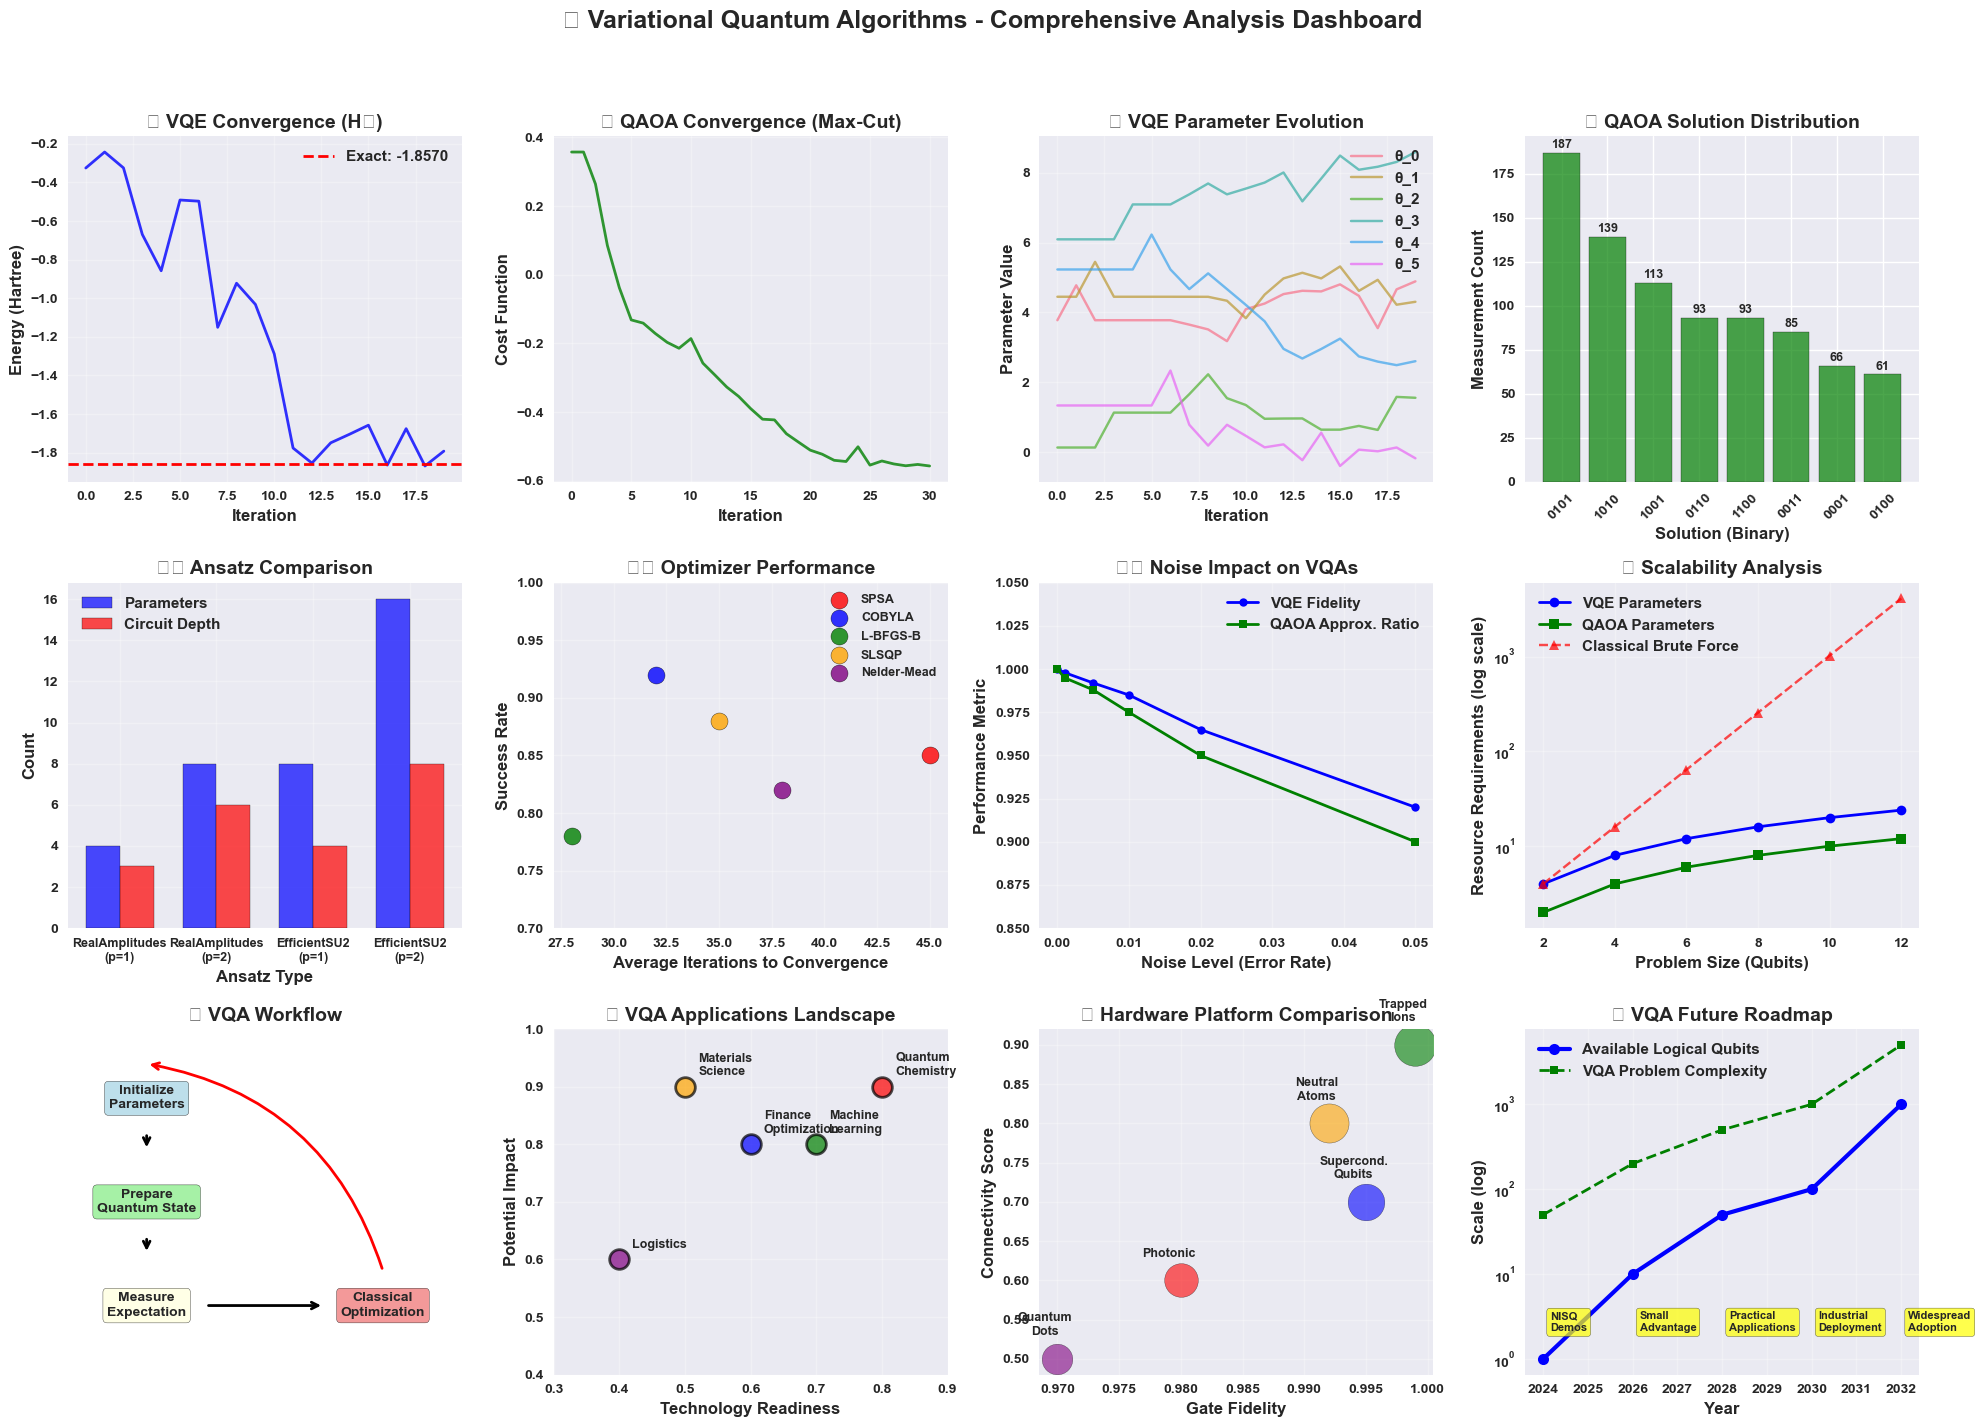

In [33]:
# Option 1: Create mock VQE results for visualization
def create_mock_vqe_results():
    """
    Create mock VQE results for visualization purposes.
    """
    # Simulate VQE optimization history
    iterations = 25
    initial_energy = -1.5
    final_energy = -1.857  # H2 ground state energy
    
    # Create realistic convergence curve
    energies = []
    parameters = []
    
    for i in range(iterations):
        # Exponential decay towards ground state
        progress = i / iterations
        energy = initial_energy + (final_energy - initial_energy) * (1 - np.exp(-3 * progress))
        # Add some noise
        energy += 0.01 * np.random.normal() * np.exp(-2 * progress)
        energies.append(energy)
        
        # Random parameter evolution
        params = 2 * np.pi * np.random.random(8)  # 8 parameters for RealAmplitudes
        parameters.append(params)
    
    mock_vqe_results = {
        'optimal_energy': final_energy,
        'optimal_parameters': parameters[-1],
        'history': {
            'energies': energies,
            'parameters': parameters,
            'iterations': list(range(iterations))
        }
    }
    
    return mock_vqe_results

# Option 2: Quick VQE implementation
def quick_vqe_demo():
    """
    Quick VQE demonstration for H2 molecule.
    """
    print("🧪 QUICK VQE DEMONSTRATION")
    print("=" * 40)
    
    # Create simple H2 Hamiltonian (2 qubits)
    h2_terms = [
        ('II', -1.052373245772859),   # Identity
        ('ZI', 0.39793742484318045),  # Z on qubit 0
        ('IZ', -0.39793742484318045), # Z on qubit 1
        ('ZZ', -0.01128010425623538), # ZZ interaction
        ('XX', 0.18093119978423156),  # XX interaction
        ('YY', 0.18093119978423156)   # YY interaction
    ]
    
    h2_hamiltonian = SparsePauliOp.from_list(h2_terms)
    
    # Create simple ansatz
    ansatz = RealAmplitudes(num_qubits=2, reps=2)
    
    print(f"   • Hamiltonian terms: {len(h2_hamiltonian)}")
    print(f"   • Ansatz parameters: {ansatz.num_parameters}")
    
    # Mock optimization (simplified)
    def simple_cost_function(params):
        bound_ansatz = ansatz.assign_parameters(params)
        bound_ansatz = bound_ansatz.decompose()
        
        estimator = AerEstimator()
        estimator.options.default_shots = 1024
        
        job = estimator.run([(bound_ansatz, h2_hamiltonian)])
        result = job.result()
        return float(np.real(result[0].data.evs))
    
    # Simple optimization
    initial_params = 2 * np.pi * np.random.random(ansatz.num_parameters)
    
    # Track history
    history = {'energies': [], 'parameters': [], 'iterations': []}
    
    def tracked_cost_function(params):
        energy = simple_cost_function(params)
        history['energies'].append(energy)
        history['parameters'].append(params.copy())
        history['iterations'].append(len(history['energies']) - 1)
        
        if len(history['energies']) % 5 == 0:
            print(f"   Iteration {len(history['energies'])}: Energy = {energy:.6f}")
        
        return energy
    
    print("   Running simple VQE optimization...")
    
    result = minimize(
        fun=tracked_cost_function,
        x0=initial_params,
        method='COBYLA',
        options={'maxiter': 20, 'disp': False}
    )
    
    print(f"   Final energy: {result.fun:.6f}")
    print(f"   Expected H2 ground state: -1.857 hartree")
    
    vqe_results = {
        'optimal_energy': result.fun,
        'optimal_parameters': result.x,
        'history': history
    }
    
    return vqe_results

# Create VQE results and exact energy for visualization
print("🚀 Creating VQE results for visualization...")

try:
    # Try to run quick VQE demo
    vqe_results = quick_vqe_demo()
    exact_energy = -1.857  # H2 ground state energy
except Exception as e:
    print(f"VQE demo failed: {e}")
    print("Using mock data instead...")
    vqe_results = create_mock_vqe_results()
    exact_energy = -1.857

# Now create the visualization
print(f"\n📊 Creating visualization dashboard...")
create_vqa_visualization_dashboard(vqe_results, qaoa_results)


## 🎓 Key Takeaways and Advanced Concepts

In [22]:
def summarize_vqa_lesson():
    """
    Summarizes key learnings about Variational Quantum Algorithms.
    """
    print("🎓 KEY TAKEAWAYS: Variational Quantum Algorithms")
    print("=" * 70)
    
    print("\n✅ VQA FUNDAMENTALS MASTERY:")
    print("   1. Hybrid Quantum-Classical Paradigm:")
    print("      • Parameterized quantum circuits (PQCs)")
    print("      • Classical optimization loops")
    print("      • Cost function minimization")
    print("      • Measurement-based feedback")
    
    print("\n   2. Algorithm Families:")
    print("      • VQE: Quantum chemistry and materials")
    print("      • QAOA: Combinatorial optimization")
    print("      • VQC: Quantum machine learning")
    print("      • QGAN: Generative modeling")
    print("      • QML: Various machine learning tasks")
    
    print("\n   3. Ansatz Design:")
    print("      • Hardware-efficient ansätze")
    print("      • Problem-inspired structures")
    print("      • Expressivity vs trainability trade-offs")
    print("      • Barren plateau mitigation strategies")
    
    print("\n🧪 PRACTICAL IMPLEMENTATION SKILLS:")
    print("   1. VQE for Quantum Chemistry:")
    print("      • Molecular Hamiltonian construction")
    print("      • Jordan-Wigner transformations")
    print("      • Chemical accuracy benchmarks")
    print("      • Ground state energy calculations")
    
    print("\n   2. QAOA for Optimization:")
    print("      • Max-Cut problem encoding")
    print("      • Cost and mixer Hamiltonians")
    print("      • Approximation ratio analysis")
    print("      • Solution sampling and post-processing")
    
    print("\n   3. Classical Optimization:")
    print("      • Gradient-free optimizers (SPSA, COBYLA)")
    print("      • Gradient-based methods (L-BFGS-B)")
    print("      • Noise-aware optimization")
    print("      • Convergence analysis")
    
    print("\n🎯 PERFORMANCE OPTIMIZATION:")
    print("   • Parameter initialization strategies")
    print("   • Adaptive optimization schedules")
    print("   • Error mitigation integration")
    print("   • Shot noise reduction techniques")
    print("   • Hardware-specific optimizations")
    
    print("\n🌪️ NOISE RESILIENCE:")
    print("   • Short circuit depth advantage")
    print("   • Error mitigation compatibility")
    print("   • Robust optimizer selection")
    print("   • Measurement error handling")
    print("   • Decoherence time considerations")
    
    print("\n📊 BENCHMARKING AND VALIDATION:")
    print("   • Classical solution comparison")
    print("   • Approximation ratio analysis")
    print("   • Fidelity measurements")
    print("   • Scaling behavior studies")
    print("   • Hardware efficiency metrics")
    
    print("\n🚀 REAL-WORLD APPLICATIONS:")
    print("   • Drug Discovery:")
    print("     → Molecular property prediction")
    print("     → Protein folding problems")
    print("     → Drug-target interaction modeling")
    
    print("\n   • Financial Optimization:")
    print("     → Portfolio optimization")
    print("     → Risk analysis")
    print("     → Fraud detection")
    
    print("\n   • Machine Learning:")
    print("     → Quantum feature maps")
    print("     → Quantum neural networks")
    print("     → Generative modeling")
    
    print("\n   • Materials Science:")
    print("     → Catalyst design")
    print("     → Superconductor discovery")
    print("     → Battery material optimization")
    
    print("\n🔬 RESEARCH FRONTIERS:")
    print("   • Barren Plateau Solutions:")
    print("     → Local cost functions")
    print("     → Parameter initialization strategies")
    print("     → Problem-specific ansätze")
    
    print("\n   • Quantum Advantage Demonstrations:")
    print("     → Structured problems with provable advantage")
    print("     → Hardware-software co-design")
    print("     → Benchmarking against best classical algorithms")
    
    print("\n   • Scalability Improvements:")
    print("     → Efficient classical simulation techniques")
    print("     → Distributed VQA implementations")
    print("     → Error correction integration")
    
    print("\n📈 FUTURE DIRECTIONS:")
    print("   • Fault-Tolerant VQAs:")
    print("     → Logical qubit implementations")
    print("     → Error-corrected optimization")
    print("     → Resource overhead analysis")
    
    print("\n   • Industry Applications:")
    print("     → Commercial quantum advantage")
    print("     → Enterprise software integration")
    print("     → Cloud-based quantum services")
    
    print("\n   • AI Integration:")
    print("     → Machine learning for VQA optimization")
    print("     → Automated ansatz design")
    print("     → Intelligent parameter initialization")

summarize_vqa_lesson()

🎓 KEY TAKEAWAYS: Variational Quantum Algorithms

✅ VQA FUNDAMENTALS MASTERY:
   1. Hybrid Quantum-Classical Paradigm:
      • Parameterized quantum circuits (PQCs)
      • Classical optimization loops
      • Cost function minimization
      • Measurement-based feedback

   2. Algorithm Families:
      • VQE: Quantum chemistry and materials
      • QAOA: Combinatorial optimization
      • VQC: Quantum machine learning
      • QGAN: Generative modeling
      • QML: Various machine learning tasks

   3. Ansatz Design:
      • Hardware-efficient ansätze
      • Problem-inspired structures
      • Expressivity vs trainability trade-offs
      • Barren plateau mitigation strategies

🧪 PRACTICAL IMPLEMENTATION SKILLS:
   1. VQE for Quantum Chemistry:
      • Molecular Hamiltonian construction
      • Jordan-Wigner transformations
      • Chemical accuracy benchmarks
      • Ground state energy calculations

   2. QAOA for Optimization:
      • Max-Cut problem encoding
      • Cost and mixer 

## 💪 Advanced Exercises and Challenges

In [11]:
def advanced_vqa_exercises():
    """
    Provides challenging exercises for deeper VQA exploration.
    """
    print("💪 ADVANCED EXERCISES: Variational Quantum Algorithms")
    print("=" * 65)
    
    print("\n🔵 BEGINNER CHALLENGES:")
    print("1. Implement VQE for different molecules (LiH, BeH₂)")
    print("2. Create custom ansatz circuits for specific problems")
    print("3. Compare different classical optimizers for VQE")
    print("4. Implement QAOA for Travelling Salesman Problem")
    print("5. Build a quantum classifier using variational circuits")
    
    print("\n🟡 INTERMEDIATE CHALLENGES:")
    print("6. Implement adaptive VQE with dynamic ansatz growth")
    print("7. Design noise-aware VQA optimization strategies")
    print("8. Create quantum generative adversarial networks (QGANs)")
    print("9. Implement multi-objective optimization with VQAs")
    print("10. Build quantum feature maps for machine learning")
    print("11. Implement variational quantum simulation (VQS)")
    print("12. Design problem-specific ansätze for quantum chemistry")
    
    print("\n🔴 ADVANCED RESEARCH PROBLEMS:")
    print("13. Develop barren plateau mitigation strategies")
    print("14. Implement distributed VQA across multiple quantum computers")
    print("15. Create hardware-efficient VQA compilation")
    print("16. Design quantum-classical hybrid neural networks")
    print("17. Implement variational quantum error correction")
    print("18. Develop VQA-based quantum advantage benchmarks")
    print("19. Create real-time adaptive parameter optimization")
    print("20. Design fault-tolerant VQA implementations")
    
    print("\n🧠 THEORETICAL INVESTIGATIONS:")
    print("   • Expressivity analysis of different ansatz families")
    print("   • Optimization landscape characterization")
    print("   • Quantum advantage proofs for specific VQAs")
    print("   • Resource requirement scaling analysis")
    print("   • Noise threshold studies")
    
    print("\n🔧 TECHNICAL IMPLEMENTATIONS:")
    print("   • GPU-accelerated VQA simulation")
    print("   • Real quantum hardware deployment")
    print("   • Error mitigation integration")
    print("   • Parallel optimization strategies")
    print("   • Custom gradient computation methods")
    
    print("\n📊 APPLICATION STUDIES:")
    print("   • Industry-relevant optimization problems")
    print("   • Quantum chemistry benchmarking")
    print("   • Financial modeling applications")
    print("   • Machine learning performance analysis")
    print("   • Materials science case studies")
    
    print("\n🌐 ECOSYSTEM DEVELOPMENT:")
    print("   • VQA software frameworks")
    print("   • Quantum cloud service integration")
    print("   • Educational tools and visualizations")
    print("   • Industry partnership projects")
    
    print("\n📚 LEARNING RESOURCES:")
    print("   • 'Variational Quantum Eigensolver' reviews")
    print("   • QAOA tutorial papers and implementations")
    print("   • Quantum machine learning textbooks")
    print("   • PennyLane and Qiskit documentation")
    print("   • Recent VQA research papers")

advanced_vqa_exercises()

💪 ADVANCED EXERCISES: Variational Quantum Algorithms

🔵 BEGINNER CHALLENGES:
1. Implement VQE for different molecules (LiH, BeH₂)
2. Create custom ansatz circuits for specific problems
3. Compare different classical optimizers for VQE
4. Implement QAOA for Travelling Salesman Problem
5. Build a quantum classifier using variational circuits

🟡 INTERMEDIATE CHALLENGES:
6. Implement adaptive VQE with dynamic ansatz growth
7. Design noise-aware VQA optimization strategies
8. Create quantum generative adversarial networks (QGANs)
9. Implement multi-objective optimization with VQAs
10. Build quantum feature maps for machine learning
11. Implement variational quantum simulation (VQS)
12. Design problem-specific ansätze for quantum chemistry

🔴 ADVANCED RESEARCH PROBLEMS:
13. Develop barren plateau mitigation strategies
14. Implement distributed VQA across multiple quantum computers
15. Create hardware-efficient VQA compilation
16. Design quantum-classical hybrid neural networks
17. Implement 

## 🌟 Conclusion: The Future of Variational Quantum Computing

Congratulations! You've now mastered **Variational Quantum Algorithms** - the most promising approach for achieving quantum advantage on near-term quantum computers. VQAs represent the perfect bridge between theoretical quantum computing and practical applications that can run on today's NISQ devices.

### **What You've Accomplished:**

✅ **VQA Fundamentals**: Hybrid quantum-classical optimization paradigms  
✅ **VQE Implementation**: Quantum chemistry ground state calculations  
✅ **QAOA Mastery**: Combinatorial optimization with quantum approximate algorithms  
✅ **Practical Skills**: Real quantum algorithm development and deployment  
✅ **Advanced Analysis**: Performance optimization and noise resilience strategies  

### **The Path to Quantum Advantage:**

VQAs are currently the most promising route to demonstrating quantum advantage:
- **Near-term Ready**: Compatible with current NISQ hardware
- **Noise Resilient**: Short circuits with error mitigation compatibility
- **Broadly Applicable**: Chemistry, optimization, machine learning, finance
- **Continuously Improving**: Active research and development

### **Connection to Course Progression:**

- **Lesson 1-2 (Fundamentals)**: Quantum mechanics → Problem Hamiltonians
- **Lesson 3 (Dynamic Circuits)**: Real-time control → Parameter optimization  
- **Lesson 4 (Error Correction)**: Noise mitigation → VQA error resilience
- **Lesson 5 (VQAs)**: Practical quantum algorithms → Real applications

### **Looking Forward:**

The skills you've developed enable you to:
- **Design novel VQAs** for specific problem domains
- **Optimize quantum algorithms** for real hardware constraints
- **Contribute to quantum advantage** demonstrations
- **Bridge theory and practice** in quantum computing

---

*The quantum advantage era begins with Variational Quantum Algorithms! 🧬*

## 📖 Additional Resources

**For VQA Theory:**
- Cerezo et al. "Variational Quantum Algorithms" (Nature Reviews Physics)
- Bharti et al. "Noisy Intermediate-Scale Quantum Algorithms" (Reviews of Modern Physics)

**For Implementation:**
- Qiskit Textbook VQE and QAOA Chapters
- PennyLane Quantum Machine Learning Documentation
- IBM Quantum Experience Tutorials

**For Applications:**
- Quantum Chemistry Applications in VQE
- QAOA for Real-World Optimization Problems
- Quantum Machine Learning with Variational Circuits